In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd

In [2]:
print(tensorflow.__version__)
print(tensorflow.keras.__version__)

2.3.0
2.4.0


### Create Some Data

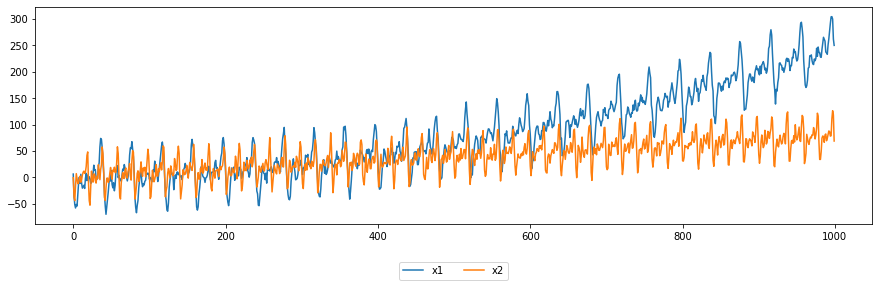

In [3]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Split sequences to 80% train set and 20% test set
We’ve just created two sequences, x1 and x2, by combining sin waves, trend, and random noise. Next we will preprocess x1 and x2.

In [4]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)
print(t.shape[0])

800
1000


### Detrending
It is not a must to detrend time series. However stationary time series will make model training much easier. There are many ways to detrend time series, such as taking difference of sequence with its lag1. Here for the simplicity, we assume the order of trend is known and we are just going to simply fit separate trend lines to x1 and x2, and then subtract the trend from the corresponding original sequence.

We will create index number of each position in the sequence, for easier detrending and trend recover.

In [5]:
x_index = np.array(range(len(t)))

Here we will use np.polyfit to complete this small task. Note that only the first 800 data points are used to fit the trend lines, this is because we want to avoid data leak.

In [6]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.44196438e-04  7.13475911e-03 -1.96012444e+00]
[0.07919537 0.08953438]


In [7]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

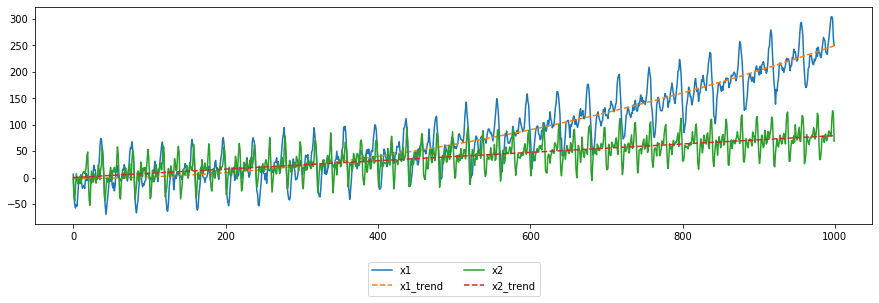

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

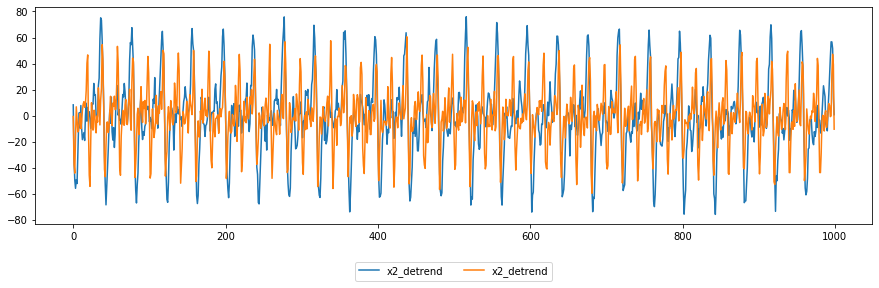

In [9]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

* the first column is the detrended x1
* the second column is the detrended x2
* the third column is the index
* the fourth column is the label (1 for train set and 0 for test set)

In [10]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[ 8.32520928e+00 -6.46020669e-01  0.00000000e+00  1.00000000e+00]
 [-3.23720266e+01 -3.72558592e+01  1.00000000e+00  1.00000000e+00]
 [-4.93000177e+01 -4.41172705e+01  2.00000000e+00  1.00000000e+00]
 ...
 [ 5.14908773e+01  4.71545650e+01  9.97000000e+02  0.00000000e+00]
 [ 1.32251223e+01  3.91194624e+01  9.98000000e+02  0.00000000e+00]
 [ 7.92331009e-01 -1.03750159e+01  9.99000000e+02  0.00000000e+00]]


### Normalize
Normalisation can help model avoid favouring large features while ignoring very small features. Here we can just simply normalise x1 and x2 by dividing the corresponding maximum values in train set.

In [11]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[75.97970772758991, 60.57952064675807, 1, 1]


In [12]:
x_normalize = np.divide(x_lbl, x_train_max)

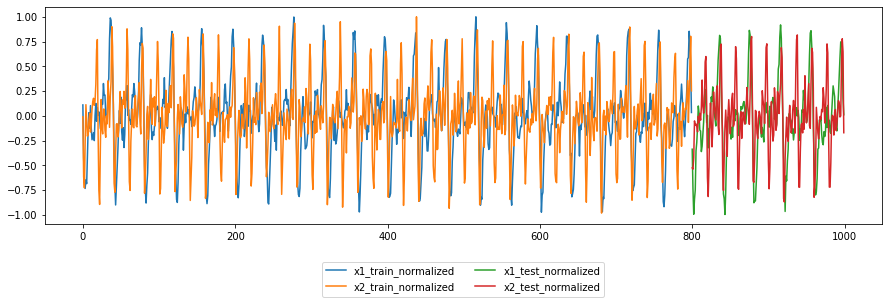

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

<img src='image/crop.png' width=600px />

In [14]:
print(len(x_normalize))

1000


In [15]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
        
        #print('{}\t~\t{} \t\t{}\t~\t{}'.format(i, i+train_len,i+train_len, i+train_len+test_len))
    return np.array(in_), np.array(out_), np.array(lbl)

In [16]:
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)

print(X_in.shape, X_out.shape, lbl.shape)


(781, 200, 3) (781, 20, 3) (781,)


```
0	~	200 		200	~	220
1	~	201 		201	~	221
2	~	202 		202	~	222
3	~	203 		203	~	223
4	~	204 		204	~	224
...
777	~	977 		977	~	997
778	~	978 		978	~	998
779	~	979 		979	~	999
780	~	980 		980	~	1000
```

In [17]:
len(x_normalize) - 200 - 20 + 1

781

In [18]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


## Model 1: Simple Seq2Seq LSTM Model

In [19]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

In [20]:
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


### The encoder LSTM

* return_sequences=False, return_state=False: return the last hidden state: state_h


In [21]:
n_hidden

100

In [22]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

In [23]:
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

Tensor("lstm/strided_slice_3:0", shape=(None, 100), dtype=float32)
Tensor("lstm/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm/while:5", shape=(None, 100), dtype=float32)


Batch normalisation is added because we want to avoid gradient explosion caused by the activation function ELU in the encoder.

In [24]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

Next, we make 20 copies of the last hidden state of encoder and use them as input to the decoder. The last cell state and the last hidden state of the encoder are also used as the initial states of decoder.

In [25]:
output_train.shape

TensorShape([None, 20, 2])

In [26]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1) # make 20 copies of the last hidden state of encoder and use them as input to the decoder


In [27]:
print('{} ---- RepeatVector x {} ---> {}'.format(encoder_last_h1.shape, output_train.shape[1],  decoder.shape))

(None, 100) ---- RepeatVector x 20 ---> (None, 20, 100)


In [28]:

decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [29]:
print(decoder)

Tensor("lstm_1/transpose_1:0", shape=(None, 20, 100), dtype=float32)


In [30]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

Tensor("time_distributed/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [31]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

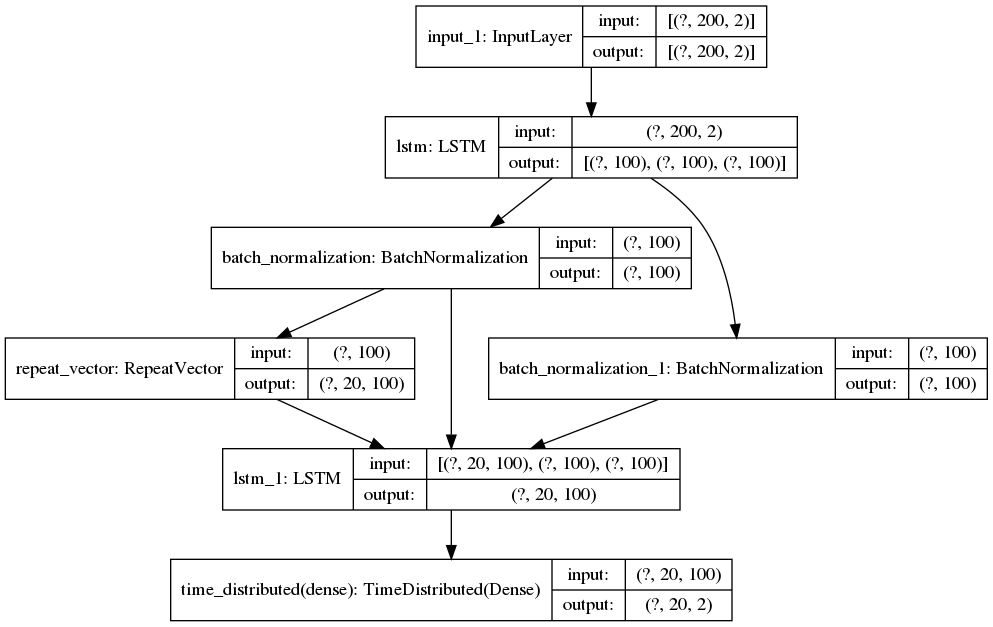

In [32]:
plot_model(model, to_file='image/model_plot_seq2seq.png', show_shapes=True, show_layer_names=True)

In [33]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 2s 428ms/step - loss: 1.3704 - mae: 0.7291 - val_loss: 0.1367 - val_mae: 0.2693
Epoch 2/100
5/5 [==============================] - 2s 364ms/step - loss: 0.1617 - mae: 0.3031 - val_loss: 0.1317 - val_mae: 0.2623
Epoch 3/100
5/5 [==============================] - 2s 369ms/step - loss: 0.1354 - mae: 0.2693 - val_loss: 0.1233 - val_mae: 0.2535
Epoch 4/100
5/5 [==============================] - 2s 365ms/step - loss: 0.1284 - mae: 0.2627 - val_loss: 0.1194 - val_mae: 0.2508
Epoch 5/100
5/5 [==============================] - 2s 362ms/step - loss: 0.1240 - mae: 0.2583 - val_loss: 0.1153 - val_mae: 0.2463
Epoch 6/100
5/5 [==============================] - 2s 375ms/step - loss: 0.1188 - mae: 0.2518 - val_loss: 0.1102 - val_mae: 0.2407
Epoch 7/100
5/5 [==============================] - 2s 364ms/step - loss: 0.1143 - mae: 0.2487 - val_loss: 0.1033 - val_mae: 0.2342
Epoch 8/100
5/5 [==============================] - 2s 371ms/step - loss: 0.1104 - m

5/5 [==============================] - 2s 362ms/step - loss: 0.0248 - mae: 0.1174 - val_loss: 0.0165 - val_mae: 0.0989
Epoch 64/100
5/5 [==============================] - 2s 368ms/step - loss: 0.0229 - mae: 0.1127 - val_loss: 0.0175 - val_mae: 0.1014
Epoch 65/100
5/5 [==============================] - 2s 370ms/step - loss: 0.0244 - mae: 0.1156 - val_loss: 0.0158 - val_mae: 0.0956
Epoch 66/100
5/5 [==============================] - 2s 377ms/step - loss: 0.0278 - mae: 0.1221 - val_loss: 0.0177 - val_mae: 0.1012
Epoch 67/100
5/5 [==============================] - 2s 368ms/step - loss: 0.0246 - mae: 0.1163 - val_loss: 0.0164 - val_mae: 0.0986
Epoch 68/100
5/5 [==============================] - 2s 375ms/step - loss: 0.0229 - mae: 0.1132 - val_loss: 0.0165 - val_mae: 0.0984
Epoch 69/100
5/5 [==============================] - 2s 363ms/step - loss: 0.0237 - mae: 0.1147 - val_loss: 0.0171 - val_mae: 0.1008
Epoch 70/100
5/5 [==============================] - 2s 370ms/step - loss: 0.0247 - mae: 0

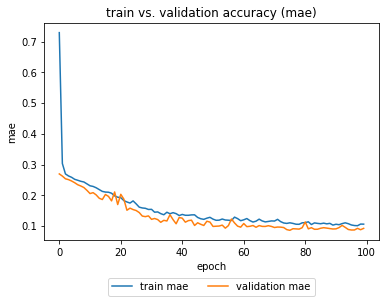

In [34]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### Prediction
The model prediction as well as the true values are unnormalised:

In [35]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 2) (181, 20, 2)


In [36]:
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)


Then we combine the unnormalised outputs with their corresponding index, so that we can recover the trend.

In [37]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


Next, we put all the outputs with recovered trend into a dictionary data_final.

In [38]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


Just a quick check to see if the prediction value distribution is reasonable:

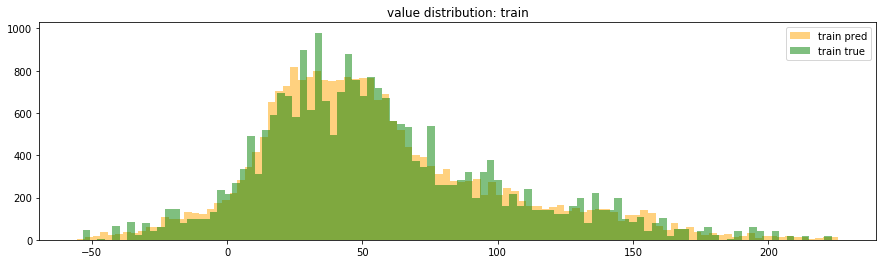

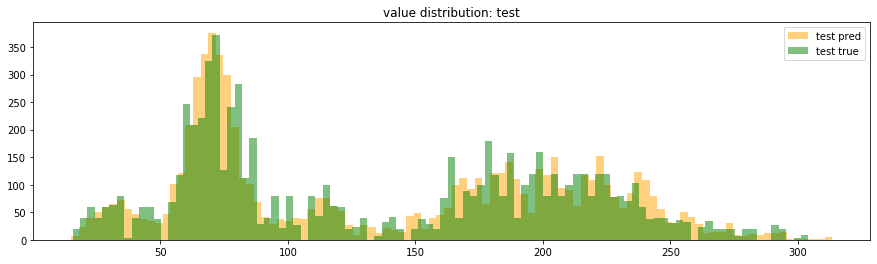

In [39]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

The data distribution of prediction and true values are almost overlapped, so we are good.

We can also plot MAE of all samples in time order, to see if there is clear pattern. The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently trained.

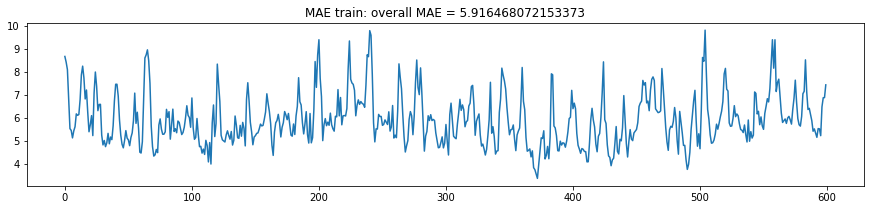

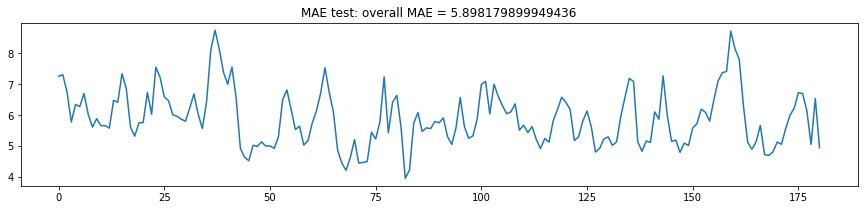

In [40]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

Based on the above plots, we can say that there are still certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.

Next we are going to check some random samples and see if the predicted lines and corresponding true lines are aligned.


8 among 20


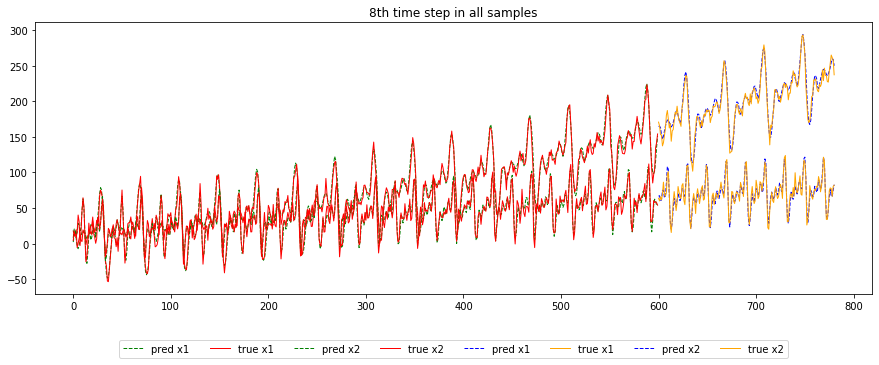

In [41]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
print('{} among {}'.format(ith_timestep, data_final[lb+'_pred'].shape[1]))

plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]

for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

Take a closer look at the prediction on test set:

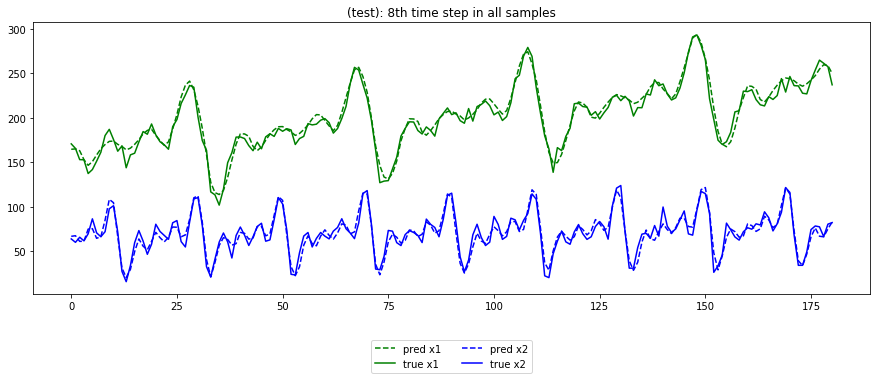

In [42]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

### References 
* Huangwei Wieniawska, Building Seq2Seq LSTM with Luong Attention in Keras for Time Series Forecasting, 2020
https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb